In [1]:
import feather
import itertools
import numpy as np
import pandas as pd
import matplotlib.colors
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from datetime import date
from currency_converter import CurrencyConverter

# dask
import dask
import dask.bag as db
import dask.dataframe as dd
from dask.distributed import Client

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

%matplotlib inline
%config IPCompleter.use_jedi = False

In [2]:
df_procedimientos = feather.read_dataframe('../data/processed/procedimientos_all_2017_07_13.feather')
print(df_procedimientos.shape)
df_procedimientos = df_procedimientos.loc[df_procedimientos.GOBIERNO == 'APF', :]
df_procedimientos = df_procedimientos.drop('GOBIERNO', axis=1)
df_procedimientos = df_procedimientos.assign(CLAVEUC=df_procedimientos.CLAVEUC_REAL)

df_procedimientos = df_procedimientos.drop('CLAVEUC_REAL', axis=1)
print(df_procedimientos.shape)
cols_id = ['NUMERO_PROCEDIMIENTO', 'CODIGO_CONTRATO', 'CODIGO_EXPEDIENTE']
df_validos = df_procedimientos.drop_duplicates(subset=cols_id, keep='first')
print(df_validos.shape)
df_validos.head(3)

(888441, 46)
(767822, 44)
(767429, 44)


,DEPENDENCIA,SIGLAS,NOMBRE_DE_LA_UC,CLAVEUC,RESPONSABLE,ESTRATIFICACION_MUC,FOLIO_RUPC,PROVEEDOR_CONTRATISTA,ESTATUS_EMPRESA,ESTRATIFICACION_MPC,IMPORTE_CONTRATO,APORTACION_FEDERAL,MONEDA,NUMERO_PROCEDIMIENTO,FORMA_PROCEDIMIENTO,TIPO_PROCEDIMIENTO,CODIGO_CONTRATO,TITULO_CONTRATO,IDENTIFICADOR_CM,TIPO_CONTRATACION,ESTATUS_CONTRATO,COMPRA_CONSOLIDADA,PLURIANUAL,CARACTER,CONTRATO_MARCO,CONVENIO_MODIFICATORIO,PROC_F_PUBLICACION,FECHA_APERTURA_PROPOSICIONES,EXP_F_FALLO,FECHA_CELEBRACION,FECHA_INICIO,FECHA_FIN,CODIGO_EXPEDIENTE,TITULO_EXPEDIENTE,PLANTILLA_EXPEDIENTE,CLAVE_PROGRAMA,CUENTA_ADMINISTRADA_POR,ANUNCIO,ARCHIVADO,SIGLAS_PAIS,RAMO,ORGANISMO,C_EXTERNO,IMPORTE_PESOS
70,AEROPUERTOS Y SERVICIOS AUXILIARES,ASA,ASA-ESTACION DE COMBUSTIBLES DEL AEROPUERTO DE...,009JZL032,JOSE LUIS ALMADA PENUNURI,MICRO,nan,MULTISERVICIOS Y ASESORIAS DEL CARIBE SA DE CV,HABILITADO,None,319200.0,NaN,MXN,IA-009JZL032-N1-2012,Mixta,INVITACION A CUANDO MENOS 3 PERSONAS,165782,"SERVICIO DE LIMPIEZA, CZM 2012",None,ADQUISICIONES,EXPIRADO,0.0,0.0,Nacional,0.0,1.0,NaT,2011-12-16 00:00:00,2011-12-19,NaT,2012-01-01,2013-02-28,115807,"SERVICIO DE LIMPIEZA, CZM 2012",Z15122015 04. Invitación a cuando menos tres N...,None,UC,https://compranet.funcionpublica.gob.mx/esop/g...,Si,MX,NaN,None,NaN,319200.0
71,AEROPUERTOS Y SERVICIOS AUXILIARES,ASA,ASA-ESTACION DE COMBUSTIBLES DEL AEROPUERTO DE...,009JZL032,JOSE LUIS ALMADA PENUNURI,MICRO,nan,ALEJANDRO ALARCON JIMON,HABILITADO,None,26097.0,NaN,MXN,AA-009JZL032-N4-2012,Presencial,ADJUDICACION DIRECTA FEDERAL,165738,MANTENIMIENTO A EXTINTORES CZM,None,SERVICIOS,EXPIRADO,0.0,0.0,Nacional,0.0,0.0,2012-08-10 15:59:00,2012-08-10 16:05:00,NaT,2012-08-20,2012-08-26,2012-12-31,242370,"SERVICIO DE MANTENIMIENTO A EXTINTORES, AD CZM...",Z15122015 07. Adjudicación Directa Nacional Ar...,None,UC,https://compranet.funcionpublica.gob.mx/esop/g...,Si,MX,NaN,None,NaN,26097.0
72,AEROPUERTOS Y SERVICIOS AUXILIARES,ASA,ASA-ESTACION DE COMBUSTIBLES DEL AEROPUERTO DE...,009JZL032,JOSE LUIS ALMADA PENUNURI,MICRO,5578,TRANSPORTE ESPECIALIZADO DE PERSONAL NACIONAL ...,HABILITADO,MEDIANA,361200.0,NaN,MXN,IA-009JZL032-N2-2012,Mixta,INVITACION A CUANDO MENOS 3 PERSONAS,148131,SERVICIO DE TRANSPORTE DE PERSONAL DE LA ESTAC...,None,SERVICIOS,EXPIRADO,0.0,0.0,Nacional,0.0,1.0,2011-12-09 14:51:00,2011-12-16 14:00:00,2011-12-19,NaT,2012-01-01,2013-02-28,116667,"SERVICIO DE TRANSPORTE DE PERSONAL, CZM 2012",Z15122015 04. Invitación a cuando menos tres N...,None,PoC,https://compranet.funcionpublica.gob.mx/esop/g...,Si,MX,NaN,None,NaN,361200.0


In [ ]:
## 125207 Anuncios con NaN

In [1]:
# df_validos.ANUNCIO.value_counts(dropna=False)

In [6]:
fechas = [
    'PROC_F_PUBLICACION',
    'FECHA_APERTURA_PROPOSICIONES',
    'EXP_F_FALLO',
    'FECHA_CELEBRACION',
    'FECHA_INICIO',
    'FECHA_FIN'
]

# df_validos.loc[:, fechas]

## INICIO y FIN el mismo día

In [3]:
meses = ["ENE", "FEB", "MAR", "ABR", "MAY", "JUN", "JUL", "AGO", "SEP", "OCT", "NOV", "DIC"]
meses = {i: m for i, m in enumerate(meses, 1)}

In [9]:
df_test = df_validos.loc[df_validos.FECHA_FIN == df_validos.FECHA_INICIO]
df_test = df_test.assign(
    DAY=df_test.FECHA_INICIO.dt.day, MONTH=df_test.FECHA_INICIO.dt.month, YEAR=df_test.FECHA_INICIO.dt.year)

cols = [
    'DEPENDENCIA', 'PROVEEDOR_CONTRATISTA', 'IMPORTE_PESOS', 'FECHA_INICIO', 'FECHA_FIN',
    'TIPO_PROCEDIMIENTO', 'FORMA_PROCEDIMIENTO', 'TIPO_CONTRATACION', 'DAY', 'MONTH', 'YEAR',
    'SIGLAS'
]

df_test = df_test.loc[:, cols]
# INSTITUTO NACIONAL DE ELECTRICIDAD Y ENERGIAS LIMPIAS
df_test = df_test.assign(SIGLAS=df_test.SIGLAS.replace('IIE', 'INEEL'))

df_test = df_test.assign(MONTH=df_test.MONTH.map(lambda x: meses[x]))
df_test.head()

,DEPENDENCIA,PROVEEDOR_CONTRATISTA,IMPORTE_PESOS,FECHA_INICIO,FECHA_FIN,TIPO_PROCEDIMIENTO,FORMA_PROCEDIMIENTO,TIPO_CONTRATACION,DAY,MONTH,YEAR,SIGLAS
281,COMISION FEDERAL DE ELECTRICIDAD,MARIA SUSANA ARAIZA AGUIRRE,60450.00,2012-08-01,2012-08-01,ADJUDICACION DIRECTA FEDERAL,Mixta,SERVICIOS,1,AGO,2012,CFE
504,SECRETARIA DE COMUNICACIONES Y TRANSPORTES,SERVILLANTAS DEL PARQUE SA DE CV,20834.48,2012-11-14,2012-11-14,ADJUDICACION DIRECTA FEDERAL,Electrónica,ADQUISICIONES,14,NOV,2012,SCT
508,SECRETARIA DE COMUNICACIONES Y TRANSPORTES,GRACIELA GARCIA GARCIA,34260.00,2012-03-12,2012-03-12,ADJUDICACION DIRECTA FEDERAL,Electrónica,ADQUISICIONES,12,MAR,2012,SCT
516,SECRETARIA DE COMUNICACIONES Y TRANSPORTES,SERVILLANTAS DEL PARQUE SA DE CV,20331.03,2012-03-07,2012-03-07,ADJUDICACION DIRECTA FEDERAL,Electrónica,ADQUISICIONES,7,MAR,2012,SCT
527,SECRETARIA DE COMUNICACIONES Y TRANSPORTES,LUCIA GUADALUPE PALOMARES VAZQUEZ,25472.00,2012-11-14,2012-11-14,ADJUDICACION DIRECTA FEDERAL,Electrónica,ADQUISICIONES,14,NOV,2012,SCT


In [6]:
# df_test.drop_duplicates(['SIGLAS', 'DEPENDENCIA']).groupby(['DEPENDENCIA']).SIGLAS.count().sort_values()

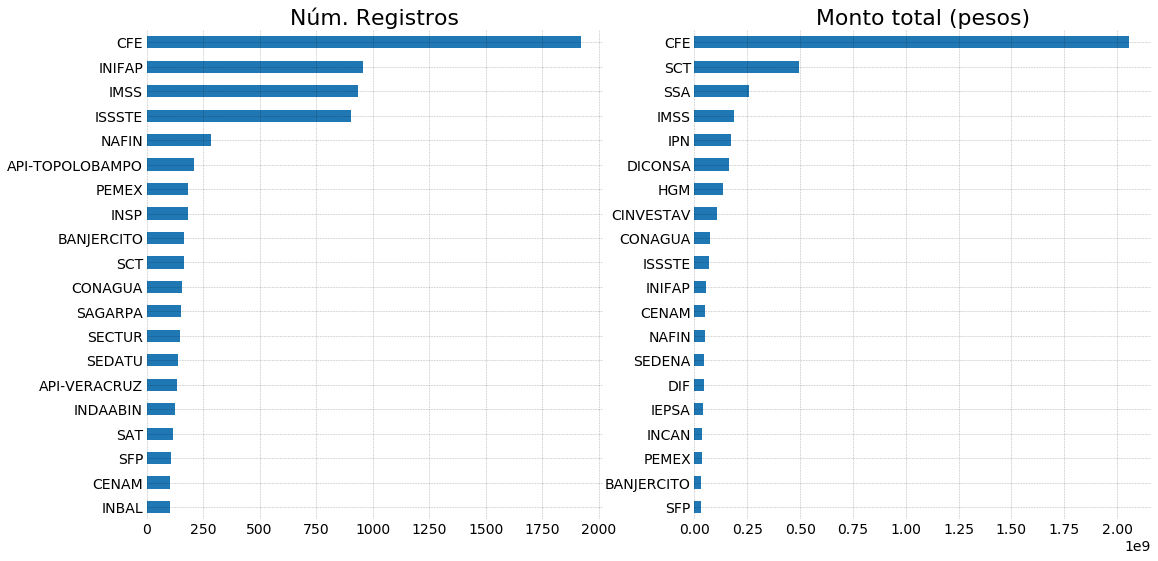

In [16]:
with plt.style.context('randy_olson_style'):
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(18, 9))
    df_aux = df_test.groupby(
        'SIGLAS'
    ).PROVEEDOR_CONTRATISTA.count().nlargest(20).sort_values()
    df_aux.index.name = None
    df_aux.plot.barh(ax=axs[0], title='Núm. Registros')
    
    df_aux = df_test.groupby(
        'SIGLAS'
    ).IMPORTE_PESOS.sum().nlargest(20).sort_values()
    df_aux.index.name = None
    df_aux.plot.barh(ax=axs[1], title='Monto total (pesos)')


In [67]:
c = set(df_test.groupby(
    'DEPENDENCIA'
).PROVEEDOR_CONTRATISTA.count().nlargest(20).sort_values().index)


m = set(df_test.groupby(
    'DEPENDENCIA'
).IMPORTE_PESOS.sum().nlargest(20).sort_values().index)

df_depen = df_test.loc[df_test.DEPENDENCIA.isin(m | c)].drop_duplicates(['DEPENDENCIA', 'SIGLAS'])[['DEPENDENCIA', 'SIGLAS']]
df_depen

,DEPENDENCIA,SIGLAS
281,COMISION FEDERAL DE ELECTRICIDAD,CFE
504,SECRETARIA DE COMUNICACIONES Y TRANSPORTES,SCT
2210,COMISION NACIONAL DEL AGUA,CONAGUA
5156,"SECRETARIA DE DESARROLLO AGRARIO, TERRITORIAL ...",SEDATU
5711,INSTITUTO DE SEGURIDAD Y SERVICIOS SOCIALES DE...,ISSSTE
7858,PETROLEOS MEXICANOS (CORPORATIVO),PEMEX
8610,"BANCO NACIONAL DEL EJERCITO, FUERZA AEREA Y AR...",BANJERCITO
10011,SISTEMA NACIONAL PARA EL DESARROLLO INTEGRAL D...,DIF
16836,SERVICIO DE ADMINISTRACION TRIBUTARIA,SAT
18784,"SECRETARIA DE AGRICULTURA, GANADERIA, DESARROL...",SAGARPA


In [68]:
c&m

{'BANCO NACIONAL DEL EJERCITO, FUERZA AEREA Y ARMADA, S.N.C.',
 'CENTRO NACIONAL DE METROLOGIA',
 'COMISION FEDERAL DE ELECTRICIDAD',
 'COMISION NACIONAL DEL AGUA',
 'INSTITUTO DE SEGURIDAD Y SERVICIOS SOCIALES DE LOS TRABAJADORES DEL ESTADO',
 'INSTITUTO MEXICANO DEL SEGURO SOCIAL',
 'INSTITUTO NACIONAL DE INVESTIGACIONES FORESTALES, AGRICOLAS Y PECUARIAS',
 'NACIONAL FINANCIERA, S.N.C.',
 'PETROLEOS MEXICANOS (CORPORATIVO)',
 'SECRETARIA DE COMUNICACIONES Y TRANSPORTES',
 'SECRETARIA DE LA FUNCION PUBLICA'}

In [71]:
df_total = df_test.groupby(['MONTH','DAY']).DEPENDENCIA.count().sort_values(ascending=False).reset_index()
df_total = df_total.assign(DIA=(df_total.MONTH.astype(str) + '-' + df_total.DAY.astype(str)))
df_total = df_total.rename(columns={'DEPENDENCIA': 'Registros_tot'})
df_total = df_total.loc[:, ['DIA', 'Registros_tot']]
df_total

,DIA,Registros_tot
0,NOV-30,204
1,DIC-31,142
2,NOV-10,139
3,OCT-31,116
4,DIC-9,104
5,ABR-30,99
6,OCT-29,88
7,MAR-1,87
8,NOV-22,83
9,DIC-15,77


In [90]:
df_dep = df_test.groupby(['MONTH','DAY', 'SIGLAS']).DEPENDENCIA.count().sort_values(ascending=False).reset_index()
df_dep = df_dep.assign(DIA=(df_dep.MONTH.astype(str) + '-' + df_dep.DAY.astype(str)))
df_dep = df_dep.drop(['MONTH', 'DAY'], axis=1)
df_dep = df_dep.rename(columns={'DEPENDENCIA': 'Registros'})
print(df_dep.shape)

siglas_dia = ['SCT', 'CFE', 'IMSS', 'ISSSTE', 'SFP', 'CONAGUA', 'NAFIN']

df_dep = df_dep.loc[df_dep.SIGLAS.isin(siglas_dia)]
print(df_dep.shape)
df_dep = df_dep.pivot(index='DIA', columns='SIGLAS', values='Registros')
print(df_dep.shape)
df_dep = df_dep.fillna(0)
df_dep = df_dep.join(df_total.set_index('DIA'), how='inner')
print(df_dep.shape)
df_dep = df_dep.sort_values('Registros_tot', ascending=False)
# suma_siglas = df_dep.loc[:, siglas_dia].sum()
df_dep = df_dep.assign(Otros=df_dep.loc[:, 'Registros_tot'] - df_dep.loc[:, siglas_dia].sum(axis=1))
df_dep = df_dep.drop('Registros_tot', axis=1)
df_dep

(4479, 3)
(1174, 3)
(365, 7)
(365, 8)


,CFE,CONAGUA,IMSS,ISSSTE,NAFIN,SCT,SFP,Otros
DIA,,,,,,,,
NOV-30,6.0,1.0,0.0,8.0,0.0,0.0,0.0,189.0
DIC-31,10.0,0.0,29.0,1.0,0.0,0.0,0.0,102.0
NOV-10,4.0,0.0,1.0,109.0,0.0,0.0,0.0,25.0
OCT-31,11.0,0.0,1.0,22.0,2.0,2.0,0.0,78.0
DIC-9,7.0,0.0,60.0,1.0,0.0,0.0,0.0,36.0
ABR-30,7.0,0.0,1.0,0.0,0.0,0.0,1.0,90.0
OCT-29,12.0,1.0,1.0,11.0,1.0,0.0,1.0,61.0
MAR-1,7.0,1.0,10.0,16.0,2.0,1.0,19.0,31.0
NOV-22,3.0,0.0,3.0,55.0,1.0,0.0,0.0,21.0


In [84]:
# BANJERCITO	CENAM	CFE	CONAGUA	IMSS	INIFAP	ISSSTE	NAFIN	PEMEX	SCT	SFP	


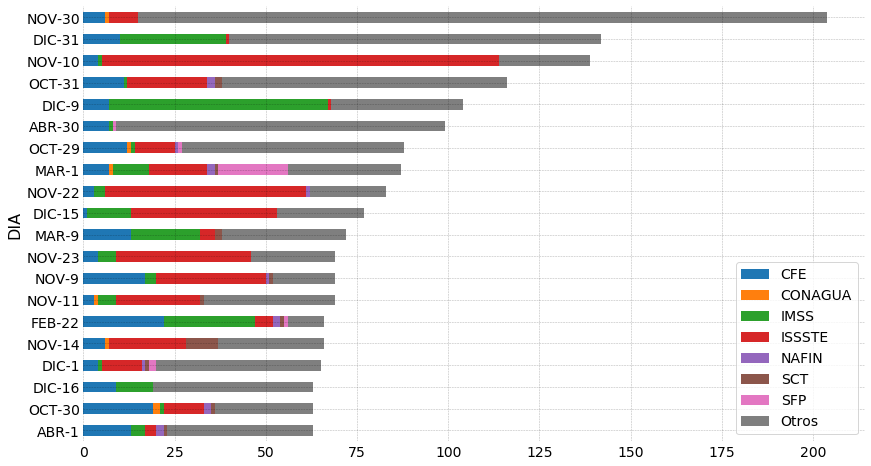

In [94]:
with plt.style.context('randy_olson_style'):
    df_dep.head(20).iloc[::-1].plot.barh(stacked=True, figsize=(14, 8))

In [31]:
df_test.groupby(
    'DEPENDENCIA'
).PROVEEDOR_CONTRATISTA.count().nlargest(20)

DEPENDENCIA
COMISION FEDERAL DE ELECTRICIDAD                                                1923
INSTITUTO NACIONAL DE INVESTIGACIONES FORESTALES, AGRICOLAS Y PECUARIAS          959
INSTITUTO MEXICANO DEL SEGURO SOCIAL                                             934
INSTITUTO DE SEGURIDAD Y SERVICIOS SOCIALES DE LOS TRABAJADORES DEL ESTADO       906
NACIONAL FINANCIERA, S.N.C.                                                      286
ADMINISTRACION PORTUARIA INTEGRAL DE TOPOLOBAMPO, S.A. DE C.V.                   210
PETROLEOS MEXICANOS (CORPORATIVO)                                                185
INSTITUTO NACIONAL DE SALUD PUBLICA                                              182
BANCO NACIONAL DEL EJERCITO, FUERZA AEREA Y ARMADA, S.N.C.                       165
SECRETARIA DE COMUNICACIONES Y TRANSPORTES                                       164
COMISION NACIONAL DEL AGUA                                                       156
SECRETARIA DE AGRICULTURA, GANADERIA, DESARROLLO RURA

DEPENDENCIA
COMISION FEDERAL DE ELECTRICIDAD                                                                2.057512e+09
SECRETARIA DE COMUNICACIONES Y TRANSPORTES                                                      4.934308e+08
SECRETARIA DE SALUD                                                                             2.584999e+08
INSTITUTO MEXICANO DEL SEGURO SOCIAL                                                            1.851694e+08
INSTITUTO POLITECNICO NACIONAL                                                                  1.749180e+08
DICONSA, S.A. DE C.V.                                                                           1.660246e+08
HOSPITAL GENERAL DE MEXICO                                                                      1.335793e+08
CENTRO DE INVESTIGACION Y DE ESTUDIOS AVANZADOS DEL INSTITUTO POLITECNICO NACIONAL              1.076084e+08
COMISION NACIONAL DEL AGUA                                                                      7.240101e+07
INSTITU

In [42]:
df_test.groupby('PROVEEDOR_CONTRATISTA').DEPENDENCIA.count().sort_values(ascending=False)

PROVEEDOR_CONTRATISTA
MEDICA BESSER SA DE CV                                                  83
COMERCIALIZADORA ARGAVI SA DE CV                                        65
PANIFICADORA EL HORNO SA DE CV                                          39
FARMACEUTICOS MAYPO SA DE CV                                            38
SERGIO OCTAVIO PAEZ LIZARRAGA                                           32
RAFAEL ALEJANDRO PONCE SANCHEZ                                          32
GRUPO FARMACOS ESPECIALIZADOS SA DE CV                                  31
SARO MEDICAL SA DE CV                                                   30
EDICIONES DEL NORTE SA DE CV                                            28
EL UNIVERSAL COMPANIA PERIODISTICA NACIONAL SA DE CV                    28
JORGE ANTONIO SANCHEZ ORTIZ                                             28
DURFA SA DE CV                                                          28
GRUPO SIA-NEKO SA DE CV                                                 27
HOS

In [40]:
df_test.groupby('PROVEEDOR_CONTRATISTA').IMPORTE_PESOS.sum().sort_values(ascending=False)

PROVEEDOR_CONTRATISTA
ENGINEERING ELECTRONICS RADIATION MEASUREMENT AND SERVICES SA DE CV    1.212265e+09
EDENRED MEXICO SA DE CV                                                3.614861e+08
ISAAC GUZMAN ROMERO                                                    1.783678e+08
GRUPO ACOPIADOR 24 DE AGOSTO SA DE CV                                  1.440551e+08
RALCA SA DE CV                                                         1.322931e+08
SI VALE MEXICO SA DE CV                                                1.208731e+08
TURBOPARTES Y SERVICIOS ESPECIALIZADOS SA DE CV                        1.112288e+08
MARCO ANTONIO GUARDIOLA SILLER                                         9.999500e+07
SABELEC SA DE CV                                                       8.848979e+07
CONSTRUCCIONES Y ELECTRIFICACIONES LOGISTICAS SA DE CV                 7.188936e+07
OPERADORA DE PROGRAMAS DE ABASTO MULTIPLE SA DE CV                     6.452532e+07
AGACEL AGREGADOS Y ASFALTOS                           

In [33]:
df_test.DEPENDENCIA.nunique(), df_test.SIGLAS.nunique()

(196, 197)

,DEPENDENCIA,PROVEEDOR_CONTRATISTA,IMPORTE_PESOS,FECHA_INICIO,FECHA_FIN,TIPO_PROCEDIMIENTO,FORMA_PROCEDIMIENTO,TIPO_CONTRATACION,DAY,MONTH,YEAR
281,COMISION FEDERAL DE ELECTRICIDAD,MARIA SUSANA ARAIZA AGUIRRE,6.045000e+04,2012-08-01,2012-08-01,ADJUDICACION DIRECTA FEDERAL,Mixta,SERVICIOS,1,8,2012
504,SECRETARIA DE COMUNICACIONES Y TRANSPORTES,SERVILLANTAS DEL PARQUE SA DE CV,2.083448e+04,2012-11-14,2012-11-14,ADJUDICACION DIRECTA FEDERAL,Electrónica,ADQUISICIONES,14,11,2012
508,SECRETARIA DE COMUNICACIONES Y TRANSPORTES,GRACIELA GARCIA GARCIA,3.426000e+04,2012-03-12,2012-03-12,ADJUDICACION DIRECTA FEDERAL,Electrónica,ADQUISICIONES,12,3,2012
516,SECRETARIA DE COMUNICACIONES Y TRANSPORTES,SERVILLANTAS DEL PARQUE SA DE CV,2.033103e+04,2012-03-07,2012-03-07,ADJUDICACION DIRECTA FEDERAL,Electrónica,ADQUISICIONES,7,3,2012
527,SECRETARIA DE COMUNICACIONES Y TRANSPORTES,LUCIA GUADALUPE PALOMARES VAZQUEZ,2.547200e+04,2012-11-14,2012-11-14,ADJUDICACION DIRECTA FEDERAL,Electrónica,ADQUISICIONES,14,11,2012
546,SECRETARIA DE COMUNICACIONES Y TRANSPORTES,LUCIA GUADALUPE PALOMARES VAZQUEZ,2.200000e+04,2012-11-14,2012-11-14,ADJUDICACION DIRECTA FEDERAL,Electrónica,ADQUISICIONES,14,11,2012
549,SECRETARIA DE COMUNICACIONES Y TRANSPORTES,GRACIELA GARCIA GARCIA,3.180258e+04,2012-02-01,2012-02-01,ADJUDICACION DIRECTA FEDERAL,Electrónica,ADQUISICIONES,1,2,2012
551,SECRETARIA DE COMUNICACIONES Y TRANSPORTES,SERVISISTEMAS LLANTEROS SA DE CV,3.321600e+04,2012-02-01,2012-02-01,ADJUDICACION DIRECTA FEDERAL,Electrónica,ADQUISICIONES,1,2,2012
553,SECRETARIA DE COMUNICACIONES Y TRANSPORTES,BALLOTINI PANAMERICANA,4.185000e+04,2012-11-14,2012-11-14,ADJUDICACION DIRECTA FEDERAL,Electrónica,ADQUISICIONES,14,11,2012
558,SECRETARIA DE COMUNICACIONES Y TRANSPORTES,GRACIELA GARCIA GARCIA,4.288000e+04,2012-11-14,2012-11-14,ADJUDICACION DIRECTA FEDERAL,Electrónica,ADQUISICIONES,14,11,2012


In [9]:
df_test.DEPENDENCIA.value_counts()

COMISION FEDERAL DE ELECTRICIDAD                                                                1923
INSTITUTO NACIONAL DE INVESTIGACIONES FORESTALES, AGRICOLAS Y PECUARIAS                          959
INSTITUTO MEXICANO DEL SEGURO SOCIAL                                                             934
INSTITUTO DE SEGURIDAD Y SERVICIOS SOCIALES DE LOS TRABAJADORES DEL ESTADO                       906
NACIONAL FINANCIERA, S.N.C.                                                                      286
ADMINISTRACION PORTUARIA INTEGRAL DE TOPOLOBAMPO, S.A. DE C.V.                                   210
PETROLEOS MEXICANOS (CORPORATIVO)                                                                185
INSTITUTO NACIONAL DE SALUD PUBLICA                                                              182
BANCO NACIONAL DEL EJERCITO, FUERZA AEREA Y ARMADA, S.N.C.                                       165
SECRETARIA DE COMUNICACIONES Y TRANSPORTES                                                 